#  DTI-based tractography 

BMED360-2021  `06-dmr-dti-tractography.ipynb`

Partly based on Matteo Visconti di Oleggio Castello & Manon de Villemejane's [notebook](https://github.com/mvdoc/grr_dti_tutorial/blob/master/dti_tutorial.ipynb) 

(assuming the `02-dmri-find-affine-fs-brainmask2dwi.ipynb` and `03-dmri-reconstruction-dti.ipynb` and `04-dmri-do-affine-reg-anat2dwi.ipynb` notebooks have been executed)

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/06-dmr-dti-tractography.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives


- Perform tractography of dMRI data using diffusion tensor estimation and deterministic tracking - deterministic because if you repeat the fiber tracking (keeping all the inputs the same) you will get exactly the same set of streamlines. 


- We learn how to save the streamlines as a Trackvis (http://trackvis.org/docs/?subsect=fileformat) file so it can be loaded into other software for visualization or further analysis. 


- The examples are based on code from the [DiPy](https://dipy.org)'s [tutorials](https://dipy.org/documentation/1.4.0./examples_index/#fiber-tracking) (check those to go deeper ...)


- Local fiber tracking is an approach used to model white matter fibers by creating streamlines from local directional information. The idea is as follows: if the local directionality of a tract/pathway segment is known, one can integrate along those directions to build a complete representation of that structure. Local fiber tracking is widely used in the field of diffusion MRI because it is simple and robust.


- In order to perform local fiber tracking, three things are needed: 
    - A method for getting directions from a diffusion data set. 
    - A method for identifying when the tracking must stop. 
    - A set of seeds from which to begin tracking. 
    
    
- This example shows how to combine the 3 parts described above to create a tractography reconstruction from a diffusion data set.



### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown
#!pip install nilearn
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [2]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [4]:
cwd = os.getcwd()

In [5]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [6]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [7]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

./data/dmri_results  exists already!


## Import libraries

In [8]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
import time
from dipy.io.image import load_nifti, load_nifti_data, save_nifti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs

### Get the diffusion MRI data

In [9]:
# Select a subject in the BIDS sample

sub = 102
ses = 1      # The only session with a dwi acquisition

In [10]:
# Read the dwi, bval and bvec information 

fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
fdwi = join(bids_dir, '%s.nii.gz' % fn)
fbval = join(bids_dir, '%s.bval' % fn)
fbvec = join(bids_dir, '%s.bvec' % fn)

data, affine, img = load_nifti(fdwi, return_img=True)

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

In [11]:
# Read the white matter mask (i.e. the binary brain mask) to restrict tracking to the white matter

fn_dwi_brain_mask = join(dmri_res,'sub_%d_tp%d_brainmask_bin_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
dwi_brain_mask_data, dwi_brain_mask_affine, dwi_brain_mask_img = load_nifti(fn_dwi_brain_mask, return_img=True)

In [12]:
# Display info about the acquisition

print('data.shape (%d, %d, %d, %d)' % data.shape)
print('\nvoxel size:', img.header.get_zooms()[:3])
print('\nbvals:\n', gtab.bvals)
print('\nbvecs (not all):\n', gtab.bvecs[:11, :])
print('\ndwi_brain_mask_data.shape (%d, %d, %d)' % dwi_brain_mask_data.shape)
print('\ndwi_brain_mask voxel size:', dwi_brain_mask_img.header.get_zooms()[:3])

data.shape (128, 128, 50, 36)

voxel size: (1.7188, 1.7188, 2.4)

bvals:
 [   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]

bvecs (not all):
 [[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 1.    -0.    -0.   ]
 [ 0.166 -0.986 -0.   ]
 [-0.11  -0.664 -0.74 ]
 [ 0.901  0.419  0.11 ]
 [-0.169  0.601 -0.781]]

dwi_brain_mask_data.shape (128, 128, 50)

dwi_brain_mask voxel size: (1.7188003, 1.7188008, 2.400001)


In [13]:
print(len(bvals), len(bvecs))

36 36


- The DWI data a 4D tensor (similar to fMRI)
- The 4th dimension represents the direction of the gradient (same index as the bvec file) with the respective b-value (same index as the bval file)


- This sequence had 30 directions with constant $b$-value: 1000

- We can visualize the direction of the gradients plotting the bvecs

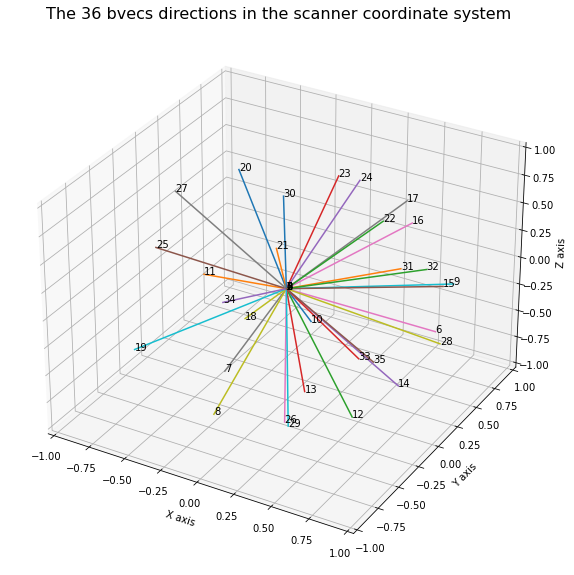

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
i = 0
for x, y, z in np.array(bvecs):
    X = [0,x]
    Y = [0,y]
    Z = [0,z]
    #ax.plot_wireframe([0, x], [0, y], [0, z])
    ax.plot(X,Y,Z)
    ax.text(x, y, z, '%d' % i)
    i = i+1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title(f'The {len(bvecs)} bvecs directions in the scanner coordinate system', size=16)
plt.show()

In [15]:
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq

In [16]:
# Just a handy function to plot 
# (modified from https://github.com/mvdoc/grr_dti_tutorial/blob/master/dti_tutorial.ipynb)

def plot_axial(img, where=25, xs=8, ys=8, ax=None, mask=None, txt=None):
    if ax is None:
        plotter = plt
        plt.figure(figsize=(xs, ys))
        plt.title(txt, size=16)
    else:
        plotter = ax
    img_ = img.copy()
    if mask is not None:
        img_[np.logical_not(mask)] = 0.
    plotter.imshow(histeq(img_[:, :, where].T), origin='lower', cmap='gray', interpolation='nearest')

**First volume in the dwi dataset**

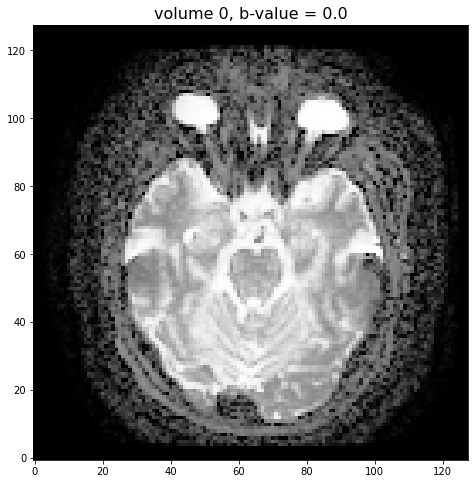

In [17]:
v = 0
txt = f'volume {v}, b-value = {bvals[v]}'
plot_axial(data[:, :, :, v], where=10, txt=txt )

## Reslicing

- Many of the methods for tractography require isotropic voxels
- Reslicing to isotropic voxels is possible and  easy in dipy, but it's better to have isotropic voxels out of the scanner,


In [18]:
print("Voxel size is {0}".format(img.header.get_zooms()[:3]))

Voxel size is (1.7188, 1.7188, 2.4)


In [19]:
from dipy.align.reslice import reslice

new_zooms = (2., 2., 2.)
data2, affine2 = reslice(data, affine, img.header.get_zooms()[:3], new_zooms)
print(data.shape, data2.shape)

(128, 128, 50, 36) (110, 110, 60, 36)


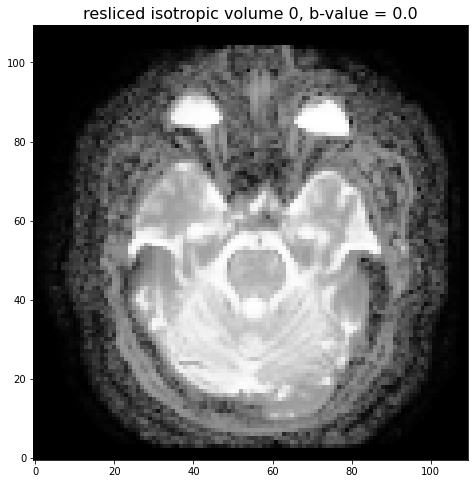

In [20]:
v = 0
txt = f'resliced isotropic volume {v}, b-value = {bvals[v]}'
plot_axial(data2[:, :, :, v], where=10, txt=txt )

### Skull stripping

- We can use many fancy methods (FSL's BET, AFNI's 3dSkullStrip, FreeSurfer, HD-BET, ...)
- Instead, we'll use a super quick way of separating an image from the background, the so-called [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method).
- We are going to perform skull-stripping on the image with $b = 0$, because it has better contrast

In [21]:
# Select the b0 data
data_b0 = data2[:, :, :, 0].squeeze()
# N.B. this values (2, 1, dilate=2) are completely ad-hoc. 
b0_mask, mask = median_otsu(data_b0, 2, 1, dilate=2)

And we get:

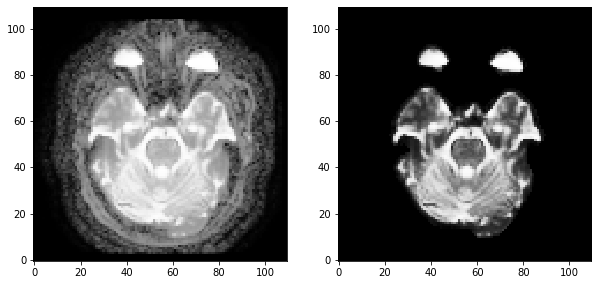

In [22]:
fig, axs = plt.subplots(1, 2, figsize=((10, 8)))
for i, ax in enumerate(axs.flatten()):
    mask_ = None if i == 0 else mask
    plot_axial(data_b0, ax=ax, mask=mask_, where=10)

### Motion correction and eddy distortions (skipped)

- At this point one should perform some sort of alignment to correct for motion
- One should also should correct for "eddy distortions", i.e. distortions caused by the rapid change in gradient

This example comes from FSL's wiki showing how eddy corrects distortions, see their page: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy

In [23]:
from IPython.display import Image, display, HTML
Image(url='https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy?action=AttachFile&do=get&target=before_after_hcp_v4.gif', width=600)

How about in this dataset?

(If you are on the Mac: get `convert` with `brew install ImageMagick` cf. https://brew.sh and https://imagemagick.org;<br>
`sudo apt install imagemagick` for Ubuntu)

In [24]:
%%time
# Save individual slices
import subprocess as sp
import os
from shutil import rmtree
if not os.path.exists('assets/dwi.gif'):
    try:
        os.makedirs('./img_out')
    except OSError:
        pass
    for i in range(1, data2.shape[-1]):
        fig, ax = plt.subplots(1, 1)
        plot_axial(data2[:, :, :, i], ax=ax, where=26)
        fig.savefig('img_out/dwi{0:02d}.png'.format(i))
        plt.close()
        
    _ = sp.check_call("convert img_out/dwi*.png -trim -delay 10 assets/dwi.gif".split())

if os.path.exists('./img_out'):
    rmtree('./img_out')

CPU times: user 112 µs, sys: 104 µs, total: 216 µs
Wall time: 189 µs


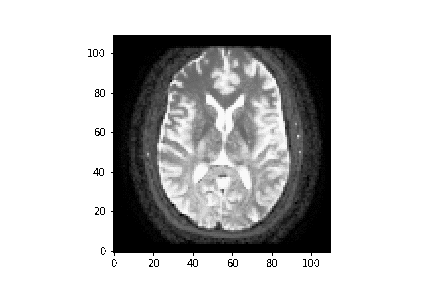

In [25]:
Image('./assets/dwi.gif', width=700)

We do see some distortions and some (not a lot of) movement during the scan. For a real analysis, you would make sure to perform some motion correction and re-alignment, as well as eddy correction.


- It's also possible to perform some denoising, but we are here going to skip that too. Read more about it on the dipy tutorial on denoising, e.g.  [Denoise images using Non-Local Means (NLMEANS)](https://dipy.org/documentation/1.4.0./examples_built/denoise_nlmeans/#example-denoise-nlmeans).

## Tractography

In the end, we want to estimate white-matter tracts, with some nice pictures. To get there, we need two things:
 1. Model the diffusion data per-voxel basis (think GLM), to get the most likely direction
 2. Find the tracts

- For step 1 we are going to use the Tensor Model, but there are many other models
- For step 2 we are going to use deterministic tractography

In [26]:
%%time
import dipy.reconst.dti as dti

# set up tensor model giving the bval/bvec information
tenmodel = dti.TensorModel(gtab)

# get masked data
data2_masked = data2.copy()
data2_masked[np.logical_not(mask)] = 0.

# fit tensor model to masked data
tenfit = tenmodel.fit(data2_masked)

CPU times: user 19.2 s, sys: 229 ms, total: 19.4 s
Wall time: 19.4 s


Now we can estimate the _Fractional Anisotropy_, an index of how directional each voxel is, i.e.

![tensor_fa](https://openi.nlm.nih.gov/imgs/512/1/3194768/PMC3194768_kjr-12-651-g001.png?keywords=condition)

Calculation of fractional anisotropy. Largest vector of diffusion ellipsoid is eigenvector 1 and its value is λ1. Shortest one is λ3 and remainder is λ2. Fractional anisotropy is calculated by each of eigenvalues. Fractional anisotropy varies from 0 (infinite isotropy) to 1 (infinite anisotropy).

(from: https://openi.nlm.nih.gov/imgs/512/1/3194768/PMC3194768_kjr-12-651-g001.png?keywords=condition)

In [27]:
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular
FA = fractional_anisotropy(tenfit.evals)
# set nans to 0 (e.g., when there is not enough signal)
FA[np.isnan(FA)] = 0

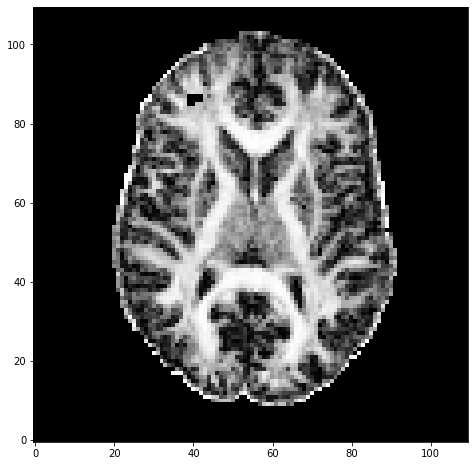

In [28]:
plot_axial(FA, where=26)

Somewhat more fancy:

(might need to `pip install fury` - in the `bmed360` environment)

In [29]:
# Get RGB colors indicating the direction from the eigen vectors
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()
# zoom in into a nice area
evals = tenfit.evals[20:70, 10:50, 10:11]
evecs = tenfit.evecs[20:70, 10:50, 10:11]

cfa = RGB[20:70, 10:50, 10:11]
cfa /= cfa.max()

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))
fvtk.record(ren, n_frames=1, out_path='assets/tensor_ellipsoids.png', size=(800, 800))

ImportError: cannot import name 'fvtk' from 'dipy.viz' (/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/dipy/viz/__init__.py)

The first thing we need to begin fiber tracking is a way of getting directions from this diffusion data set. In order to do that, we can fit the data to a Constant Solid Angle ODF Model. This model will estimate the Orientation Distribution Function (ODF) at each voxel. The ODF is the distribution of water diffusion as a function of direction. The peaks of an ODF are good estimates for the orientation of tract segments at a point in the image. Here, we use peaks_from_model to fit the data and calculated the fiber directions in all voxels of the white matter.

In [ ]:
%%time

from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=dwi_brain_mask_data)

Next we need some way of restricting the fiber tracking to areas with good directionality information. We’ve already created the white matter mask, but we can go a step further and restrict fiber tracking to those areas where the ODF shows significant restricted diffusion by thresholding on the generalized fractional anisotropy (GFA).

In [ ]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

For quality assurance we can also visualize a slice the GFA and the resulting tracking mask.

In [ ]:
import matplotlib.pyplot as plt

sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

# plt.savefig('gfa_tracking_mask.png')
plt.show()

Before we can begin tracking is to specify where to “seed” (begin) the fiber tracking. Generally, the seeds chosen will depend on the pathways one is interested in modeling. In this example, we’ll use a 2 × 2 × 2 grid of seeds per voxel, in a sagittal slice of the corpus callosum. Tracking from this region will give us a model of the corpus callosum tract. This slice has label value 2 in the labels image.